In [1]:
include("dsm.jl")

import dsm
import PyPlot
import DSP

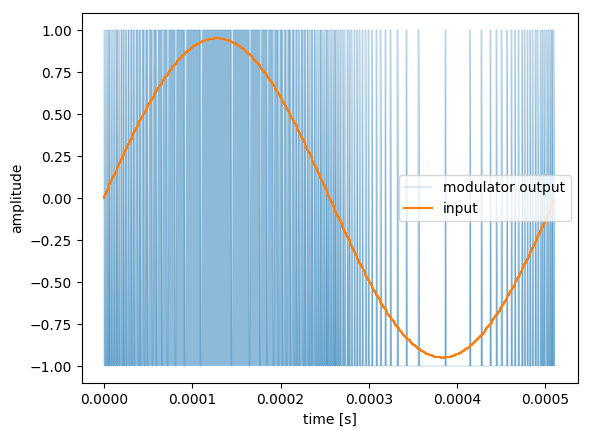

In [2]:
f_s = 1e6;
T_s = 1/f_s;

n_fft = 2^9;
k = 1;

f_i = f_s/n_fft*k;
a_i = .95;
b_i = 0;

n_i = 0;

t = 0:T_s:T_s*(n_fft-1);
inp = a_i*sin.(2*pi*f_i*t) + b_i + 2*n_i*(rand(size(t))-.5);

mod = dsm.Mod1(1.0, 1.0);
out = dsm.sim_mod(mod, inp);

q = out[1];

PyPlot.step(t, q, linewidth=.2, label="modulator output");
PyPlot.fill_between(t, q, -1.0, alpha=.5)
PyPlot.hold(true);
PyPlot.step(t, inp, label="input");
PyPlot.hold(false);
PyPlot.legend();
PyPlot.xlabel("time [s]");
PyPlot.ylabel("amplitude");

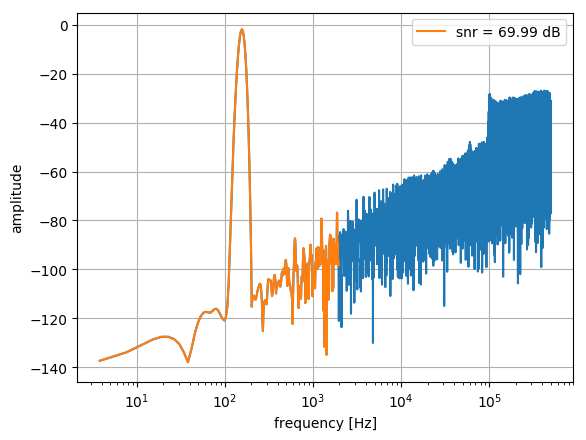

In [3]:
f_s = 1e6;           # sample frequency
T_s = 1/f_s;         # sample time

n_fft = 2^18;        # number of fft points
n_ini = 2^5;         # number of initial points for settling

k = 41;              # input frequency bin
f_i = f_s/n_fft*k;   # input frequency

a_i = .8;            # input amplitude
b_i = 0;             # input offset
n_i = 0;             # input noise power

osr = 256;           # oversampling ratio
f_bw= (f_s/2)/osr;   # noise bandwidth

t = 0:T_s:T_s*(n_fft+n_ini-1);
inp = a_i*sin.(2*pi*f_i*t) + b_i + n_i*randn(size(t));

mod = dsm.Mod1(1.0, 1.0);
out = dsm.sim_mod(mod, inp);

q = out[1][end-n_fft+1:end];
q_snr = dsm.snr(q, f_i, f_bw, f_s);

w = DSP.Windows.kaiser(n_fft, 20);
wf = mean(w);
Y_inp = fft(q.*w)/n_fft/wf;

f = linspace(0, f_s/2, (n_fft/2+1));

PyPlot.semilogx(f, 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/2+1)])));
PyPlot.hold(true);
PyPlot.semilogx(f[1:trunc(Int64, n_fft/(2*osr))], 20*log10.(2*abs.(Y_inp[1:trunc(Int64, n_fft/(2*osr))])), label=@sprintf("snr = %.2f dB", q_snr))
PyPlot.hold(false);
PyPlot.xlabel("frequency [Hz]");
PyPlot.ylabel("amplitude");
PyPlot.grid();
PyPlot.legend();

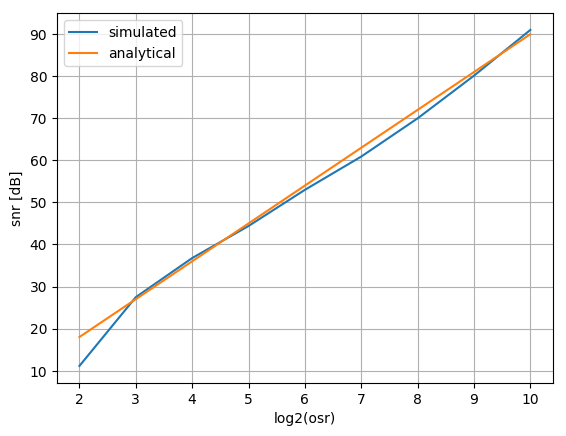

In [4]:
osr_sw = [2^i for i in 2:10];
f_bw_sw = f_s/2./osr_sw;
snr_sw = zeros(length(osr_sw));

for (i, f_bw) in enumerate(f_bw_sw)
    snr_sw[i] = dsm.snr(q, f_i, f_bw, f_s);
end

PyPlot.plot(log2.(osr_sw), snr_sw, label="simulated");
PyPlot.hold(true);
PyPlot.plot(log2.(osr_sw), 9*log2.(osr_sw), label="analytical");
PyPlot.hold(false)
PyPlot.xlabel("log2(osr)");
PyPlot.ylabel("snr [dB]")
PyPlot.grid();
PyPlot.legend();